In [29]:
import random
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib
import copy
import itertools
import pickle

In [2]:
def compute_weight(G, edge_coeff, tri_coeff):
    '''
    Compute the probability weight on graph G
    
    Args:
        G: The graph to weigh
        edge_coeff: The coefficient on the number of edges
        tri_coeff: The coefficient on the number of triangles
    Returns:
        weight: The weight of the selected graph
    '''
    
    edge_count = len(G.edges())
    triangles = sum(nx.triangles(G).values())
    weight = np.exp(np.float128(edge_count * edge_coeff + triangles * tri_coeff))
    return weight

In [3]:
def permute_graph(G):
    '''
    Return a new graph with an edge randomly added or subtracted from G
    
    Args:
        G: The graph to permute
    '''
    
    G1 = copy.deepcopy(G)
    d = nx.density(G1)
    r = random.random()
    if (r < 0.5 or d == 0) and d != 1:
        # Add an edge
        nodes = list(G.nodes)
        # n1 = random.choice(nodes)
        # n2 = random.choice(nodes)
        # NOTE: should I force n1 != n2, or is it okay? i.e:
        n1, n2 = [n for n in random.sample(nodes, 2)]
        G1.add_edge(n1, n2)
    else:
        # Remove an edge
        n1, n2 = random.choice(list(G1.edges))
        G1.remove_edge(n1, n2)
    return G1

In [4]:
def mcmc(G, edge_coeff, tri_coeff, n):
    '''
    Use MCMC to generate a sample of networks from an ERG distribution
    
    Args:
        G: The observed network, with which to seed the graph
        edge_coeff: The coefficient on the number of edges
        tri_coeff: The coefficient on the number of triangles
        n: The number of samples to generate
    Returns:
        graphs: A list of graph objects 
    '''
    
    v = len(G) # Number of nodes in G
    p = nx.density(G) # Probability of a random edge existing
    current_graph = nx.erdos_renyi_graph(v, p) #Random graph
    current_w = compute_weight(G, edge_coeff, tri_coeff)
    graphs = []
    num_attempts = []
    while len(graphs) < n:
        print(f"{len(graphs)} out of {n} graphs completed.")
        num_attempts.append(len(graphs))
        new_graph = permute_graph(current_graph)
        while not nx.is_connected(new_graph):
            new_graph = permute_graph(current_graph)
        new_w = compute_weight(new_graph, edge_coeff, tri_coeff)
        if new_w > current_w or random.random() < (new_w/current_w):
            graphs.append(new_graph)
            current_w = new_w
    plt.plot(range(len(num_attempts)), num_attempts)
    return graphs

In [5]:
def sum_weights(graphs, edge_coeff, tri_coeff):
    '''
    Sum the probability weights on every graph in graphs
    
    Args:
        graphs: A list of graph objects
        edge_coeff: The coefficient on the number of edges
        tri_coeff: The coefficient on the number of triangles
    Returns:
        total: The sum of the probability weights on every graph in graphs
    '''
    
    total = 0.0
    for g in graphs:
        total += compute_weight(g, edge_coeff, tri_coeff)
    return total

In [6]:
def fit_ergm(G, coeff_samples=100, graph_samples=1000, return_all=True):
    '''
    Use MCMC to sample possible coefficients, and return the best fits
    
    Args:
        G: The observed graph to fit
        coeff_samples: The number of coefficient combinations to sample
        graph_samples: The number of graphs to sample for each set of coeffs
        return_all: If True, return all sampled values. Otherwise, only best.
    Returns:
        If return_all=False, returns a tuple of values:
            (best_edge_coeff, best_triangle_coeff, best_p)
        where p is the estimated probability of observing the graph G with
        the fitted parameters.
        
        Otherwise, return a tiple of lists:
            (edge_coeffs, triangle_coeffs, probs)
    '''
    
    edge_coeffs = [0]
    tri_coeffs = [0]
    probs = [0]
    
    while len(probs) < coeff_samples:
        # Make the jump size larger earlier on, and smaller toward the end
        w = coeff_samples/50.0
        s = np.sqrt(w/len(probs))
        # Pick new coefficients to try:
        edge_coeff = edge_coeffs[-1] + random.normalvariate(0, s)
        tri_coeff = tri_coeffs[-1] + random.normalvariate(0, s)
        # Check how likely the observed graph is under this distribution:
        graphs = mcmc(G, edge_coeff, tri_coeff, graph_samples)
        sum_weight = sum_weights(graphs, edge_coeff, tri_coeff)
        p = compute_weight(G, edge_coeff, tri_coeff) / sum_weight
        # Decide whether to accept the jump:
        if p > probs[-1] or random.random() < (p / probs[-1]):
            edge_coeffs.append(edge_coeff)
            tri_coeffs.append(tri_coeff)
            probs.append(p)
        else:
            edge_coeffs.append(edge_coeffs[-1])
            tri_coeffs.append(tri_coeffs[-1])
            probs.append(probs[1])
        # Return either the best values, or all of them:
        if not return_all:
            i = np.argmax(probs)
            best_p = probs[i]
            best_edge_coeff = edge_coeffs[i]
            best_tri_coeff = tri_coeffs[i]
            return (best_edge_coeff, best_tri_coeff, best_p)
        else:
            return (edge_coeffs, tri_coeffs, probs)

In [7]:
n = 50
G = nx.erdos_renyi_graph(n, 1/np.log(n))
while not nx.is_connected(G):
    G = nx.erdos_renyi_graph(n, 1/np.log(n))
# nx.draw(G)
# G = nx.florentine_families_graph()

In [8]:
# %%time
# graphs = mcmc(G, -1.25, 0.15, 10000)

In [9]:
# %%time
# edge_coeffs, triangle_coeffs, probs = fit_ergm(G, 10, 10, True)

0 out of 10 graphs completed.
1 out of 10 graphs completed.
2 out of 10 graphs completed.
2 out of 10 graphs completed.
2 out of 10 graphs completed.
2 out of 10 graphs completed.
2 out of 10 graphs completed.
2 out of 10 graphs completed.
2 out of 10 graphs completed.
2 out of 10 graphs completed.
2 out of 10 graphs completed.
3 out of 10 graphs completed.
3 out of 10 graphs completed.
3 out of 10 graphs completed.
3 out of 10 graphs completed.
3 out of 10 graphs completed.
3 out of 10 graphs completed.
3 out of 10 graphs completed.
3 out of 10 graphs completed.
3 out of 10 graphs completed.
3 out of 10 graphs completed.
3 out of 10 graphs completed.
3 out of 10 graphs completed.
3 out of 10 graphs completed.
3 out of 10 graphs completed.
3 out of 10 graphs completed.
4 out of 10 graphs completed.
4 out of 10 graphs completed.
4 out of 10 graphs completed.
4 out of 10 graphs completed.
4 out of 10 graphs completed.
4 out of 10 graphs completed.
4 out of 10 graphs completed.
4 out of 1

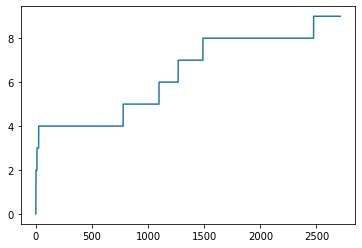

In [10]:
%%time
edge_coeffs, triangle_coeffs, probs = fit_ergm(G, 100, 10, True)

In [11]:
i = np.argmax(probs)
print(max(probs))
print(edge_coeffs[i])
print(triangle_coeffs[i])

5.6141522508022224307e-82
-0.9424652758974139
-0.8613535267548271


0 out of 50 graphs completed.
0 out of 50 graphs completed.
0 out of 50 graphs completed.
0 out of 50 graphs completed.
0 out of 50 graphs completed.
0 out of 50 graphs completed.
0 out of 50 graphs completed.
0 out of 50 graphs completed.
1 out of 50 graphs completed.
1 out of 50 graphs completed.
1 out of 50 graphs completed.
1 out of 50 graphs completed.
1 out of 50 graphs completed.
1 out of 50 graphs completed.
2 out of 50 graphs completed.
2 out of 50 graphs completed.
3 out of 50 graphs completed.
4 out of 50 graphs completed.
4 out of 50 graphs completed.
4 out of 50 graphs completed.
4 out of 50 graphs completed.
4 out of 50 graphs completed.
5 out of 50 graphs completed.
5 out of 50 graphs completed.
5 out of 50 graphs completed.
5 out of 50 graphs completed.
5 out of 50 graphs completed.
6 out of 50 graphs completed.
6 out of 50 graphs completed.
6 out of 50 graphs completed.
6 out of 50 graphs completed.
6 out of 50 graphs completed.
6 out of 50 graphs completed.
6 out of 5

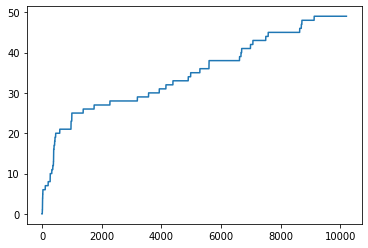

In [12]:
%%time
graphs_fitted = mcmc(G, edge_coeffs[i], triangle_coeffs[i], n)

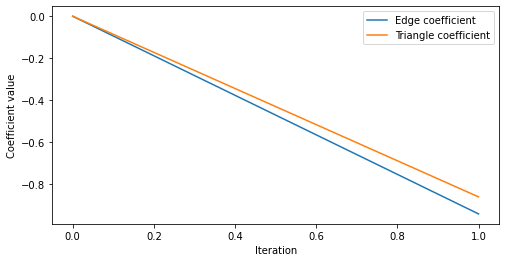

In [13]:
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111)
p1, = ax.plot(edge_coeffs)
p2, = ax.plot(triangle_coeffs)
ax.set_ylabel("Coefficient value")
ax.set_xlabel("Iteration")
l = ax.legend([p1, p2], ["Edge coefficient", "Triangle coefficient"])

In [14]:
# import pickle
# with open(f"{n}nGraphs", "wb") as fp:   #Pickling
#     pickle.dump(graphs_fitted, fp)

In [15]:
# import pickle
# n=50
# with open(f"{n}nGraphs", "rb") as fp:   # Unpickling
#     b = pickle.load(fp)

In [16]:
# import networkx as nx
# nx.draw(b[1])

In [17]:
Gs = []
colour_maps = []
G = graphs_fitted[10]
for node in range(n):
    new_G = nx.Graph()
    new_colour_map = []
    for i in G.neighbors(node):
        new_G.add_edge(i, node)
        for j in G.neighbors(i):
            if j in G.neighbors(node):
                new_G.add_edge(i, j)
    for node_1 in new_G:
        # print(node, n)
        if node_1 == node:
            new_colour_map.append('red')
        else:
            new_colour_map.append('blue')
    colour_maps.append(new_colour_map)
    Gs.append(new_G)
# nx.draw(new_G, with_labels=True)

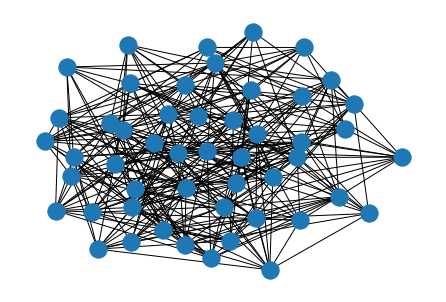

In [18]:
nx.draw(G)

In [19]:
print(max([G.degree[i] for i in range(n)]))

22


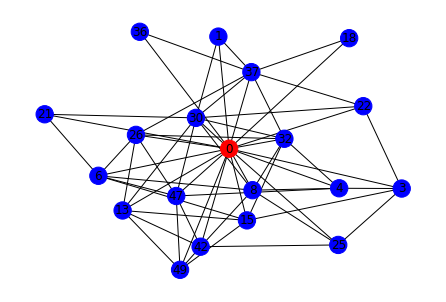

In [20]:
nx.draw(Gs[0], node_color=colour_maps[0], with_labels=True)

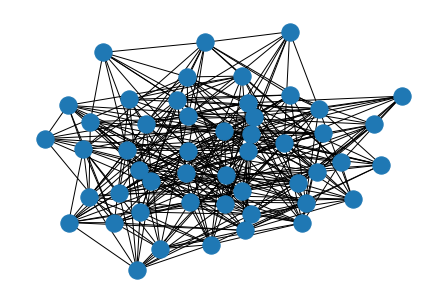

In [21]:
nx.draw(G)

In [22]:
egonet_matricies = []

for g in Gs:
    egonet_matricies.append([nx.adjacency_matrix(g).todense(), [list(i) for i in itertools.product([0, 1], repeat=len(g))]])

/var/folders/9f/zym06w255zs6f4g_71_6g5p40000gn/T/ipykernel_68564/597798131.py:4: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  egonet_matricies.append([nx.adjacency_matrix(g).todense(), [list(i) for i in itertools.product([0, 1], repeat=len(g))]])
/var/folders/9f/zym06w255zs6f4g_71_6g5p40000gn/T/ipykernel_68564/597798131.py:4: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  egonet_matricies.append([nx.adjacency_matrix(g).todense(), [list(i) for i in itertools.product([0, 1], repeat=len(g))]])


In [26]:
print(len(egonet_matricies[0]))
print(egonet_matricies[0][0])

2
[[0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 0 1 0 0 0 1 0 1 1 1 0 1 0 0 1 0 0 0]
 [1 1 1 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 1 1]
 [0 1 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 1 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0]
 [0 1 0 0 1 0 0 0 0 0 1 0 1 0 0 0 1 1 0 0]
 [0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0]
 [0 1 1 0 0 1 0 0 1 0 1 0 1 0 0 1 0 0 0 0]
 [0 1 1 1 0 1 1 0 0 1 0 0 0 0 1 0 0 0 0 0]
 [0 1 1 0 0 1 0 0 0 0 0 0 1 0 1 1 0 1 0 0]
 [0 1 0 0 0 0 1 0 0 1 0 1 0 1 1 0 0 0 0 0]
 [0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 1 0 1 0 0 0 0 0 0 1 1 1 0 0 0 1 0 0 0]
 [0 1 0 0 0 0 0 0 1 1 0 1 0 0 0 0 1 1 0 0]
 [0 1 1 0 0 0 1 0 0 0 0 0 0 0 1 1 0 1 0 0]
 [0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 1 1 0 0 0]
 [0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


In [31]:
file_name = "data_for_elle.pkl"

open_file = open(file_name, "wb")
pickle.dump(egonet_matricies, open_file)
open_file.close()